## Libraries

In [202]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Dimensionality Reduction
from sklearn.decomposition import PCA

# UMAP (optional – requires pip install umap-learn)
import umap

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample

# Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA


# Utility / Settings
import warnings

## 1. Data Wrangling







**Objective:** We want to convert  the raw biochemical patient data into a structured feature matrix on which we can perform geometric and statistical modeling.

* Removed patient ID to avoid artificial structure.
* Audited and corrected variable types to prevent parsing errors and preserve numerical precision.
* Assessed missingness to reduce bias in structure estimation:

  * Excluded records with >30% missing values.
  * Applied **median imputation (numerical)** and **most-frequent imputation (categorical)** to preserve distributional robustness.
* Enforced biological plausibility constraints (valid age range and non-negative lab values) to prevent clustering artifacts from erroneous entries.
* Encoded categorical variables for compatibility with numerical algorithms
* Separated the categories from the rest of the data
* The dataset is imbalanced (≈87% Blood Donor). This can dominate the geometry of the feature space clustering algorithms may primarily learn the majority “healthy” pattern and treat disease profiles as tiny fragments or outliers. To ensure the analysis is not driven only by class prevalence, we create a balanced subsample by downsampling Blood Donors to match the total number of non-donor cases. This is a sensitivity analysis: we keep the full dataset as the main reference, and we re-run key unsupervised steps on the balanced cohort to check whether the discovered structure remains consistent when the healthy majority no longer overwhelms the signal.

In [203]:
# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("HepatitisCdata.csv")
#df.head()

In [204]:
# -----------------------------
# Remove non-informative columns
# -----------------------------
df = df.drop(columns=["Unnamed: 0"])
#df.head()

In [205]:
# -----------------------------
# Verify and enforce data types
# -----------------------------
categorical_cols = ["Sex", "Category"]
numeric_cols = [c for c in df.columns if c not in categorical_cols]

# Convert numeric columns safely
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [206]:
# -----------------------------
# Handle Missing Values
# -----------------------------

# Step 1: Remove rows with excessive missingness (>30%)
row_missing_fraction = df.isna().mean(axis=1)
df = df.loc[row_missing_fraction <= 0.30].copy()

# Step 2: Impute remaining missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
df[["Sex"]] = cat_imputer.fit_transform(df[["Sex"]])



In [207]:
# -----------------------------
# Remove biologically impossible values
# -----------------------------

# Age constraints
if "Age" in df.columns:
    df = df[(df["Age"] > 0) & (df["Age"] < 120)].copy()

# Lab marker (non-negative)
lab_markers = ["ALB","ALP","ALT","AST","BIL","CHE","CHOL","CREA","GGT","PROT"]
lab_markers = [c for c in lab_markers if c in df.columns]

for c in lab_markers:
    df = df[df[c] >= 0].copy()


In [208]:
# -----------------------------
# Encode categorical variables
# -----------------------------
sex_map = {"m": 1, "M": 1, "male": 1, "Male": 1,
           "f": 0, "F": 0, "female": 0, "Female": 0}

df["Sex_bin"] = df["Sex"].map(sex_map)

# Robust fillna: if mode is empty (all NaN), fallback to 0
mode_series = df["Sex_bin"].mode(dropna=True)
fill_value = int(mode_series.iloc[0]) if not mode_series.empty else 0
df["Sex_bin"] = df["Sex_bin"].fillna(fill_value).astype(int)



In [209]:
# -----------------------------
# FEATURE MATRIX
# -----------------------------

# Keep Category for post interpretation
y_category = df["Category"].copy()

# Build feature matrix X (exclude Category and original Sex)
feature_cols = ["Age", "Sex_bin"] + lab_markers
X = df[feature_cols].copy()

# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)
#print(X_scaled.mean())
#print(X_scaled.std())

print("X_scaled shape:", X_scaled.shape)
print("Unique categories:", sorted(pd.unique(y_category)))
#X.head()


X_scaled shape: (615, 12)
Unique categories: ['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis']


In [210]:
# -----------------------------
# LOG-TRANSFORMATION
# -----------------------------
# Skewed variables in this dataset, noticed in 2.1 distributional analysis
skewed_vars = [c for c in ["ALT", "AST", "GGT", "BIL", "CREA"] if c in df.columns]
print("\nSkewed variables to log transform:", skewed_vars)

# Log-transform skewed variables
for c in skewed_vars:
    if c in X.columns:
        X[c] = np.log1p(X[c])


Skewed variables to log transform: ['ALT', 'AST', 'GGT', 'BIL', 'CREA']


In [211]:
# ============================================================
# BALANCED SUBSAMPLING (Sensitivity Analysis)
# ============================================================

# Keep full dataset copy
df_full = df.copy()

# Identify majority class automatically
class_counts = df["Category"].value_counts()
majority_label = class_counts.idxmax()

df_majority = df[df["Category"] == majority_label]
df_minority = df[df["Category"] != majority_label]

n_minority = len(df_minority)

# Downsample majority
df_majority_down = df_majority.sample(
    n=n_minority,
    random_state=42
)

# Combine + shuffle
df_balanced = (
    pd.concat([df_majority_down, df_minority], axis=0)
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print("\nBalanced distribution:")
print(df_balanced["Category"].value_counts())

# -----------------------------
# REBUILD BALANCED FEATURES
# -----------------------------
X_bal = df_balanced[feature_cols].copy()

X_bal_scaled = pd.DataFrame(
    scaler.fit_transform(X_bal),
    columns=feature_cols
)

y_bal = df_balanced["Category"].copy()

print("\nBalanced X shape:", X_bal_scaled.shape)


Balanced distribution:
Category
0=Blood Donor             82
3=Cirrhosis               30
1=Hepatitis               24
2=Fibrosis                21
0s=suspect Blood Donor     7
Name: count, dtype: int64

Balanced X shape: (164, 12)


## 2. Exploratory Data Analysis (EDA)


### 2.1 Distribution Analysis


**Objective** : We want to identify skewness and potential heavy tails and will make log transformation in Data Wrangling section where apropriate.

**Observations** :
* CREA, BIL, GGT, ALT, AST exhibit strong positive skewness.Meaning thier upper quantiles (95th–99th) are substantially higher than median values, this indicates a heavy right tails.
* For this fact we consider logarithmic transformation before applying distance-based models.


In [212]:
# -----------------------------
# 2.1 Distribution Analysis
# -----------------------------

# Identify skewness of each numeric variable
skewness = df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)
print("\nSkewness (descending):\n", skewness)

# Skewed variables in this dataset
# done in Data Wrangling
print("\nSkewed variables to log transform:", skewed_vars)

#Quantiles to see outliers
print("\nQuantiles for skewed vars:")
print(df[skewed_vars].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))



Skewness (descending):
 CREA    15.169291
BIL      8.385437
GGT      5.632734
ALT      5.510989
AST      4.940327
ALP      4.730036
CHOL     0.381835
Age      0.267134
CHE     -0.110233
ALB     -0.177189
PROT    -0.964607
dtype: float64

Skewed variables to log transform: ['ALT', 'AST', 'GGT', 'BIL', 'CREA']

Quantiles for skewed vars:
          ALT      AST      GGT    BIL     CREA
0.50   23.000   25.900   23.300   7.30   77.000
0.75   33.050   32.900   40.200  11.20   88.000
0.90   46.700   52.480   77.300  18.00   99.000
0.95   62.030   91.840  108.500  24.03  106.000
0.99  118.086  187.322  292.534  87.64  134.826


### 2.2 Summary statistics


**Objective** :
 * We want to understand the quantitative baseline for each feature before modeling.
 * We want to examin summary statistics such as mean, standard deviation, minimum, and maximum values. Also we want to look at robust statistics such as median and interquartile range (IQR)
 * We'll also assess overall central tendency, dispersion, and potential extreme values within the dataset.
* The main objective is understand the data structure before we apply unsupervised learning techniques.


**Observations** :
* Log-transformed variables (ALT, AST, BIL, GGT, CREA) now show reduced skewness and stabilized dispersion.
* ALP remains highly dispersed with extreme maximum values relative to its IQR.
* ALB, CHOL, PROT, and Age display relatively symmetric distributions with moderate variability.


In [213]:
# -----------------------------
# Relative dispersion (CV)
# -----------------------------
cv = (X.std(numeric_only=True) / X.mean(numeric_only=True)).sort_values(ascending=False)
print("\nCoefficient of Variation (CV):")
print(cv)


Coefficient of Variation (CV):
Sex_bin    0.795190
ALP        0.375920
BIL        0.282716
CHE        0.269093
GGT        0.222310
Age        0.212097
CHOL       0.209335
ALT        0.193270
AST        0.144367
ALB        0.138775
PROT       0.074929
CREA       0.063210
dtype: float64


In [214]:
# -----------------------------
# 2.2 Summary statistics
# -----------------------------
print("\n--- Summary statistics (features only) ---")
print(X.describe().T)

print("\n--- Robust stats (median + IQR) ---")
median = X.median(numeric_only=True)
q1 = X.quantile(0.25, numeric_only=True)
q3 = X.quantile(0.75, numeric_only=True)
iqr = q3 - q1
robust_stats = pd.DataFrame({"Q1": q1, "median": median, "Q3": q3, "IQR": iqr})
print(robust_stats)


--- Summary statistics (features only) ---
         count       mean        std        min        25%        50%  \
Age      615.0  47.408130  10.055105  19.000000  39.000000  47.000000   
Sex_bin  615.0   0.613008   0.487458   0.000000   0.000000   1.000000   
ALB      615.0  41.620732   5.775935  14.900000  38.800000  41.950000   
ALP      615.0  68.222927  25.646364  11.300000  52.950000  66.200000   
ALT      615.0   3.181725   0.614934   0.641854   2.856470   3.178054   
AST      615.0   3.405217   0.491600   2.451005   3.117950   3.292126   
BIL      615.0   2.218744   0.627274   0.587787   1.840550   2.116256   
CHE      615.0   8.196634   2.205657   1.420000   6.935000   8.260000   
CHOL     615.0   5.366992   1.123499   1.430000   4.620000   5.300000   
CREA     615.0   4.359903   0.275590   2.197225   4.219508   4.356709   
GGT      615.0   3.341741   0.742901   1.704748   2.815409   3.190476   
PROT     615.0  72.044390   5.398238  44.800000  69.300000  72.200000   

      

### 2.3 Correlation between Features



**Objective** :
* Examine linear relationships between biochemical markers to detect redundancy and structural dependencies in the dataset.
*  By computing the correlation matrix and identifying the strongest absolute correlations, we assess which variables convey overlapping information. Such as expected relationships between liver enzymes (ALT and AST) or between albumin and total protein
* Assess potential multicollinearity which can inflate dimensionality without adding independent information, which can bias distance-based algorithms.
* The heatmap provides a visual representation of these correlation patterns
* The main objective is to justifies the use of dimensionality reduction techniques.

**Observations Correlation matrix** :
* Moderate correlations are observed, with the strongest pair **AST–GGT (r ≈ 0.56)**. No correlation exceeds conventional multicollinearity thresholds (|r| ≥ 0.7), indicating absence of severe redundancy.
* The correlation matrix reveals structured linear relationships between several hepatic biomarkers, reflecting shared physiological mechanisms rather than statistical artifacts.
* The strongest association, **AST–GGT (r ≈ 0.56)**, suggests coordinated elevation of liver injury and cholestatic markers, consistent with hepatic inflammatory processes.
* **ALB–PROT (r ≈ 0.55)** shows a clinically coherent relationship, as albumin constitutes a major fraction of total serum protein.
* **CHE–CHOL (r ≈ 0.42)** exhibits moderate coupling, reflecting related hepatic synthetic and metabolic functions.

**Observations Correlation Heatmap** :

* Visual blocks confirm moderate positive correlations among liver enzymes.
* Clear grouping between ALB–PROT and CHE–CHOL.
* No deep red blocks, absence of severe multicollinearity.
* Feature space shows structured physiological relationships rather than independence.



--- Top absolute correlations (excluding self-correlations) ---
AST      GGT     0.557091
ALB      PROT    0.549975
AST      BIL     0.442286
CHE      CHOL    0.420215
ALB      CHE     0.375817
Sex_bin  CREA    0.318524
ALT      CHE     0.316859
CHE      PROT    0.293041
ALT      GGT     0.280237
BIL      GGT     0.276495
ALP      GGT     0.272101
Sex_bin  GGT     0.270872
ALT      AST     0.257557
BIL      CHE     0.252557
Sex_bin  ALT     0.242398
dtype: float64


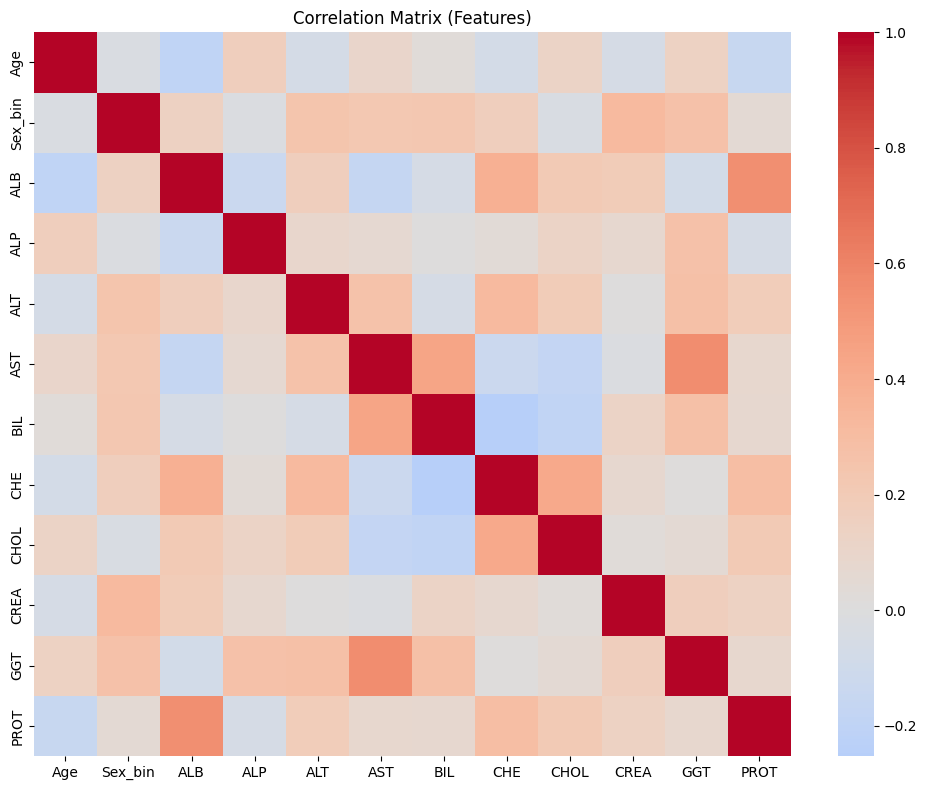

In [215]:
# -----------------------------
# 2.3.a Correlation matrix (redundancy detection)
# -----------------------------
corr = X.corr(numeric_only=True)

print("\n--- Top absolute correlations (excluding self-correlations) ---")
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top_pairs = upper.stack().sort_values(ascending=False).head(15)
print(top_pairs)

# -----------------------------
# 2.3.b Correlation Heatmap
# -----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Features)")
plt.tight_layout()
plt.show()


### 2.4 Variance Check



**Objective** :
Detect features with very low variance that may add little information to clustering.

**Observations**:
* All variables contribute meaningful variability.
* Log-transformed liver enzymes (ALT, AST, GGT, CREA) now display reduced and stabilized variance, confirming effective variance compression.
* ALP and Age show higher variance, because of broader biological dispersion.
* Sex_bin shows moderate variance (0.24), consistent with a balanced binary distribution.

In [216]:
# -----------------------------
# 2.4 Variance Check
# -----------------------------
variance = X.var(numeric_only=True).sort_values()

print("\nFeature variances (ascending):")
print(variance)

#Low variance features
low_variance = variance[variance < 0.01]
print("\nPotential low-variance features:")
print(low_variance)


Feature variances (ascending):
CREA         0.075950
Sex_bin      0.237616
AST          0.241671
ALT          0.378143
BIL          0.393473
GGT          0.551902
CHOL         1.262251
CHE          4.864924
PROT        29.140974
ALB         33.361430
Age        101.105146
ALP        657.736004
dtype: float64

Potential low-variance features:
Series([], dtype: float64)



### 2.5  Pairwise plots


**Objective** :
We want to visually assess relationships between selected biomarkers to confirm correlation patterns, detect potential outliers, and identify geometric structure before applying dimensionality reduction and clustering.

**Observations**:

* Log-transformed variables (ALT, AST, BIL, GGT, CREA) exhibit symmetric and concentrated distributions, with reduced extreme upper tails.
* ALB, PROT, and Age display approximately symmetric, unimodal distributions with moderate dispersion.
* A clear positive linear relationship is visible between **ALT and AST**, confirming expected hepatic enzyme coupling.
* **AST–GGT** shows a moderate positive trend, consistent with correlated hepatocellular and cholestatic activity.
* **ALB–PROT** demonstrates a strong linear association with tight clustering, confirming structural redundancy due to albumin being a major protein component.
* CREA appears tightly concentrated after transformation, with minimal dispersion relative to other biomarkers.
* Relationships are generally linear but moderately dispersed, suggesting partial shared variance rather than deterministic coupling.
* No visibly distinct clusters emerge in pairwise projections, indicating that potential group structure (if present) is likely embedded in higher-dimensional space.
* The global geometry suggests a continuous physiological spectrum rather than sharply separated subgroups.




Pairplot variables used: ['Age', 'ALB', 'PROT', 'ALT', 'AST', 'BIL', 'GGT', 'CREA']


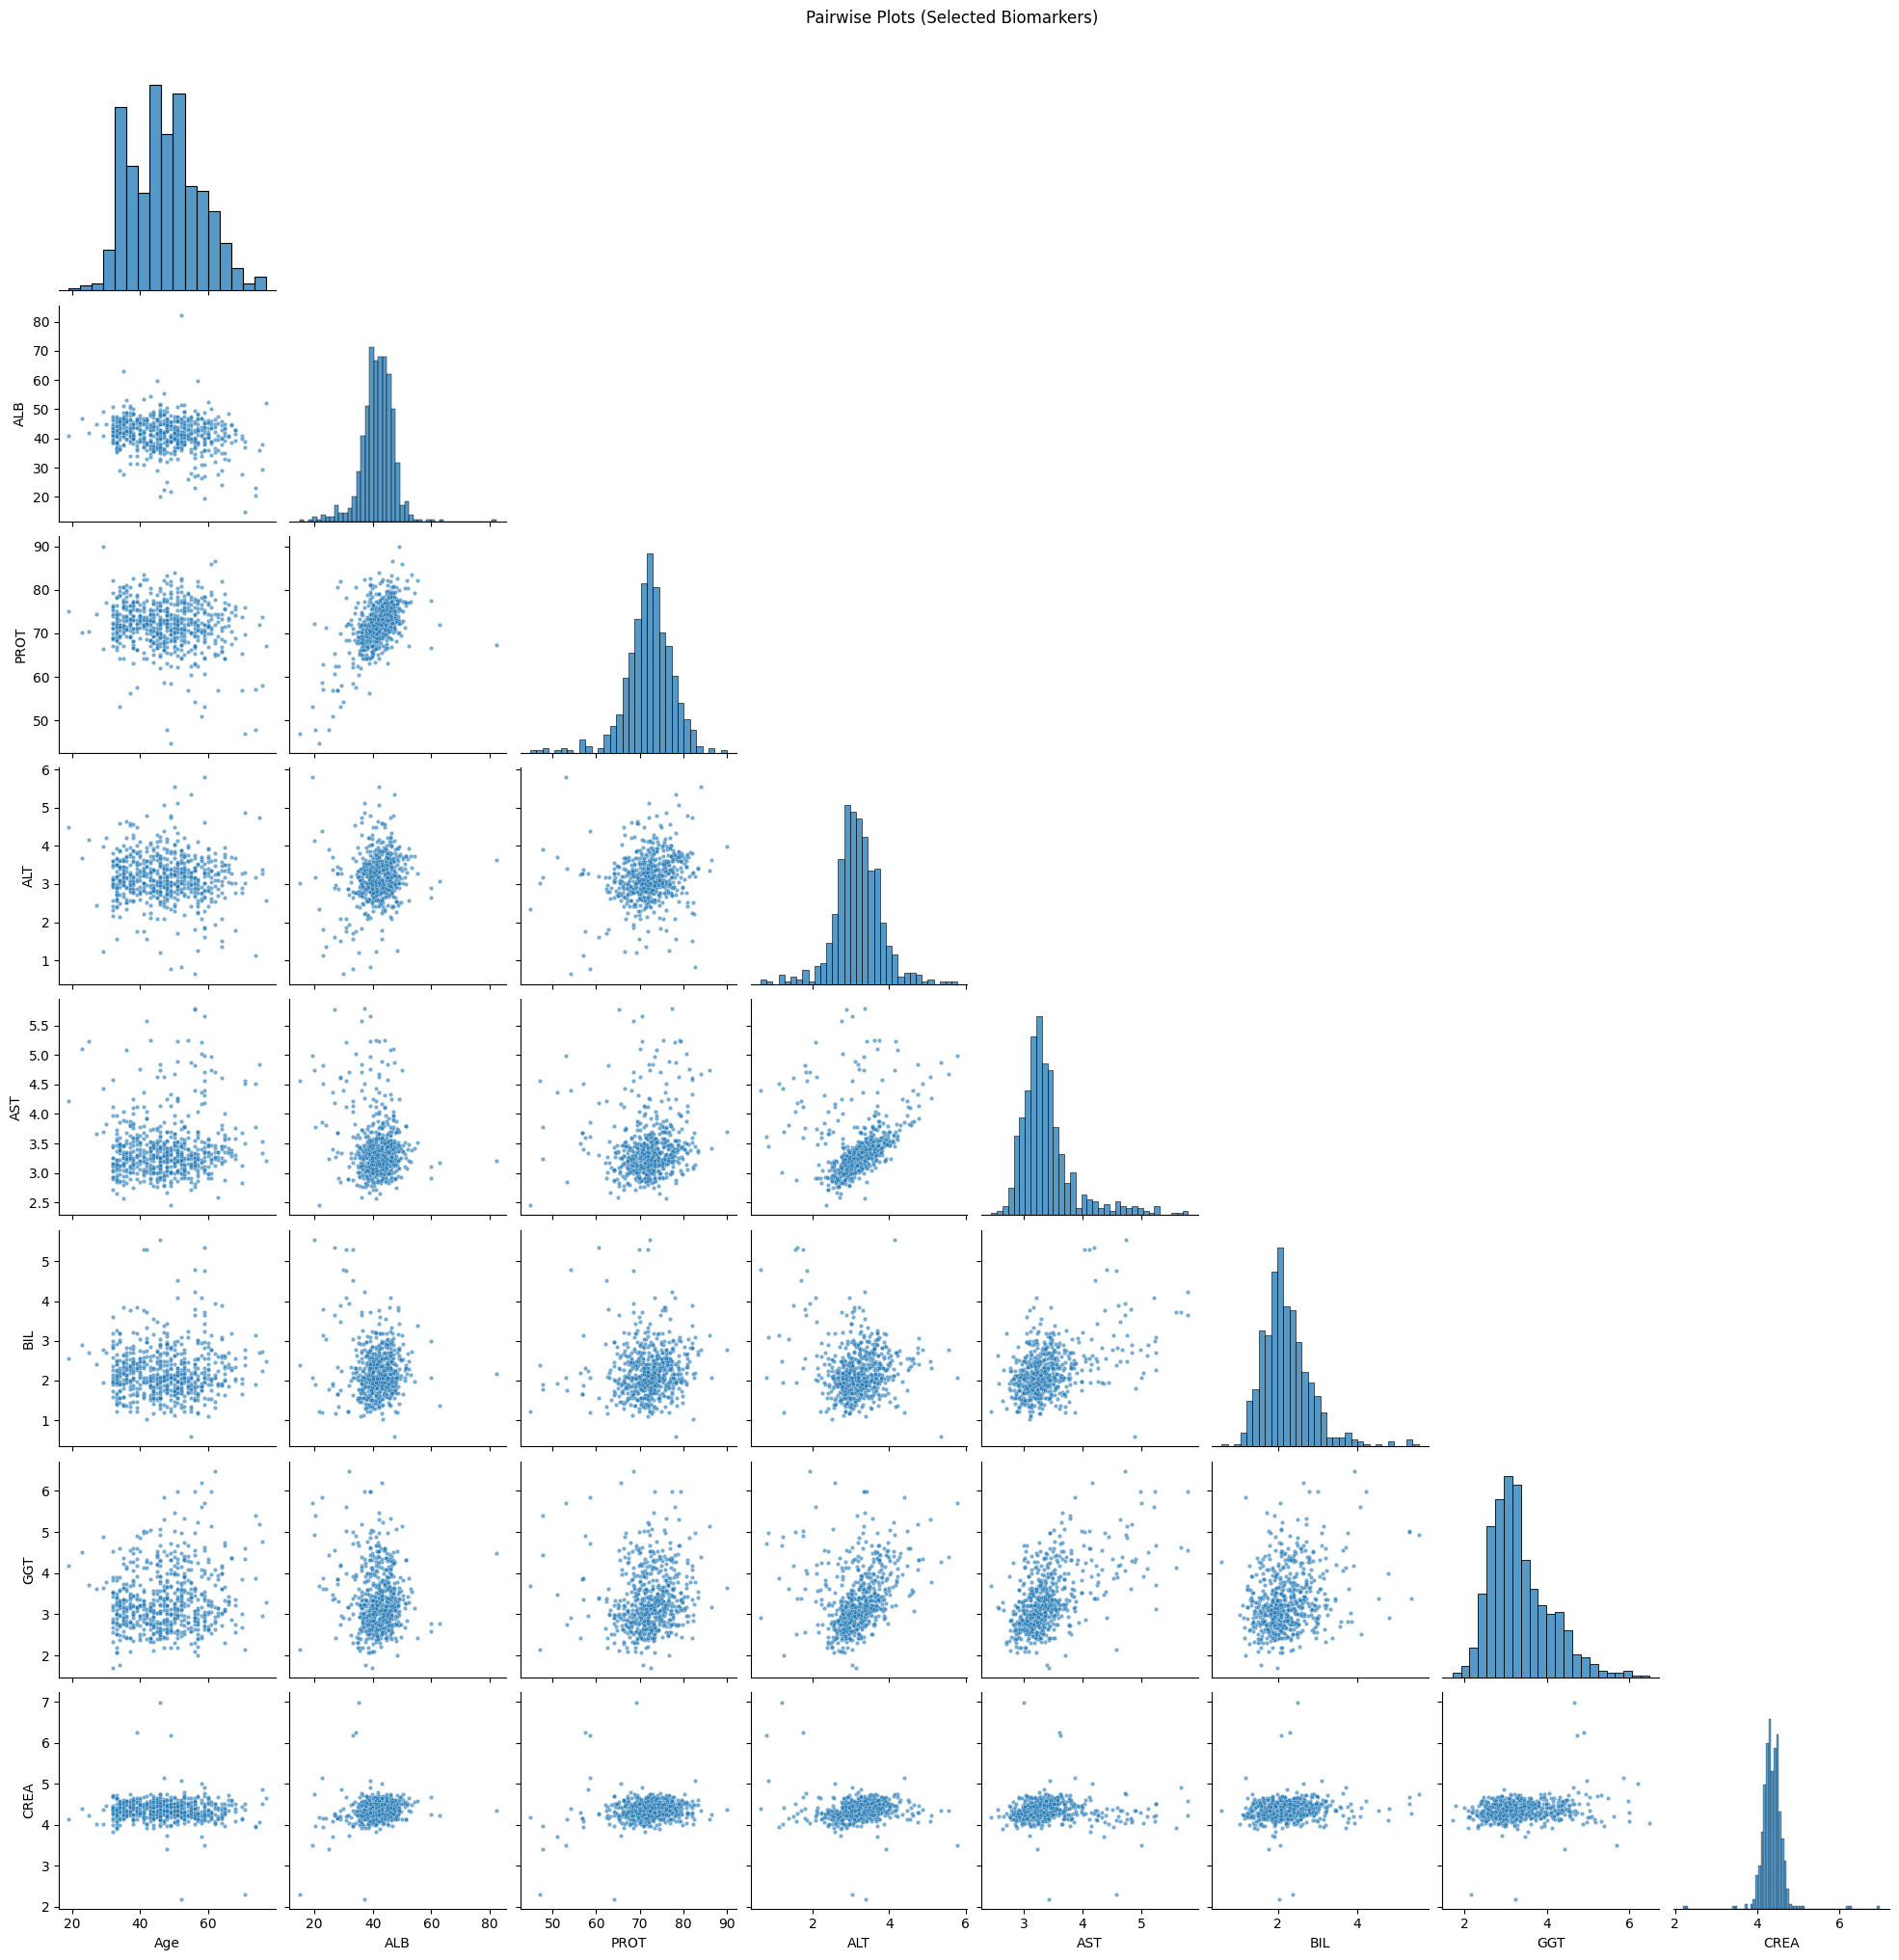

In [217]:
# -----------------------------
# 2.5 Pairwise plots
# -----------------------------
selected = [c for c in ["Age", "ALB", "PROT", "ALT", "AST", "BIL", "GGT", "CREA"] if c in X.columns]

print("\nPairplot variables used:", selected)

sns.pairplot(X[selected], corner=True, plot_kws={"s": 10, "alpha": 0.6})
plt.suptitle("Pairwise Plots (Selected Biomarkers)", y=1.02)
plt.show()



### 2.6 Early anomaly detection


**Objective** :
The objective of this step is to identify extreme upper-tail observations by counting values above the 99th percentile for selected biomarkers..

**Observations**:
 * Each variable has approximately 6–7 observations above the 99th percentile, which is statistically expected (~1% of 615 ≈ 6
* Extreme values are present but proportionally limited.
* Heavy tails are confirmed for liver enzymes despite log transformation.


In [218]:
# -----------------------------
# 2.6 Early anomaly detection (EDA-level)
# -----------------------------
high_quantile = 0.99
extreme_flags = {}

for c in selected:
    if c in X.columns and pd.api.types.is_numeric_dtype(X[c]):
        threshold = X[c].quantile(high_quantile)
        extreme_flags[c] = int((X[c] > threshold).sum())

print(f"\n--- Number of points above the {high_quantile:.2f} quantile (selected vars) ---")
for k, v in extreme_flags.items():
    print(f"{k}: {v}")



--- Number of points above the 0.99 quantile (selected vars) ---
Age: 6
ALB: 7
PROT: 7
ALT: 7
AST: 7
BIL: 7
GGT: 7
CREA: 7


## 3. Unsupervised Learning Modeling


### 3.1 PCA – Latent Structure Extraction


During the exploratory analysis, we observed moderate correlations between several biochemical markers (ALT–AST, ALB–PROT, CHE–CHOL). These relationships indicate that the feature space contains partially overlapping information. Since these correlated markers reflect shared physiological mechanisms, such as hepatic injury, cholestasis, and synthetic function, their variability may be expressed through a smaller number of latent biological dimensions. Thus we can ask :

<br>

**Problematique** :
Can the biochemical redundancy observed in EDA be compressed into a reduced number of orthogonal latent components that preserve the dominant physiological variance structure?

<br>

Principal Component Analysis (PCA) transforms correlated variables into a set of orthogonal components that successively maximize explained variance.s. Wechoose PCA to address the moderate redundancy. By projecting the standardized feature space into principal components, we aim to compress correlated biochemical information.
In conclusion this will allows us to identify interpretable physiological axes and reduce dimensionality before we apply clustering.

<br>

**Observations** :
PCA reavealed to structured but distributed variance pattern across biomarkers :
* The first principal component, PC1 explains approximately 20.5% of total variance, followed by PC2 (15.8%) and PC3 (11.8%).
* The first three components capture roughly **48%** of total variability, while the first six components account for approximately **74%**.
* The scree plot shows a gradual decay without a sharp elbow.
* These findings indicate that variance is not dominated by a single latent factor. Instead, biochemical variability is distributed across multiple physiological dimensions, reflecting biological heterogeneity rather than a single pathological gradient.

<br>

**PC1 Observations**:
PC1 represents a dominant hepatic functional contrast:
* Positive loadings: **ALB, CHE, PROT, CHOL**
* Negative loadings: **AST, GGT, BIL**
* This component opposes preserved hepatic synthetic capacity against biochemical markers of liver injury and cholestasis.
* This suggests that PC1 captures a physiological axis opposing preserved liver synthetic capacity against biochemical evidence of liver injury or cholestasis.
* Interpretation : patients with high PC1 scores may reflect stronger synthetic function and lower inflammatory burden, while low PC1 scores may reflect active hepatic injury.

<br>

**PC2 Observations**:
PC2 seems to capture coordinated elevation of hepatic enzymes:
* Strong positive loadings are observed for GGT, ALT, ALP, AST, CHE, and PROT
* This suggests a component associated with enzyme elevation and hepatobiliary involvement.
* Interpretation : PC2  component reflects co-elevation of injury and cholestatic markers.

<br>

**PC3 Observations**:
* Load positive : Age, ALP, and CHOL,
* Load negative : PROT and BIL.
* This suggests a demographic–metabolic dimension that partially separates age-related variation from protein synthesis or inflammatory activity.

<br>

**Conclusion**
In conclusion, the correlated biomarkers combine into latent components. The biochemical variability is distributed across multiple physiological axes rather than one overwhelming factor.


In [219]:
# -----------------------------
# 3.1 PCA – Variance Structure
# -----------------------------

# Fit PCA on scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

print("\nExplained variance ratio per component:")
for i, var in enumerate(explained_variance[:10], 1):
    print(f"PC{i}: {var:.4f}")

print("\nCumulative explained variance:")
print(np.cumsum(explained_variance)[:10])




Explained variance ratio per component:
PC1: 0.2051
PC2: 0.1583
PC3: 0.1182
PC4: 0.0954
PC5: 0.0817
PC6: 0.0772
PC7: 0.0623
PC8: 0.0541
PC9: 0.0489
PC10: 0.0391

Cumulative explained variance:
[0.20514353 0.36341346 0.48158101 0.57696018 0.6586163  0.73584766
 0.79815895 0.85227536 0.90119719 0.94028448]


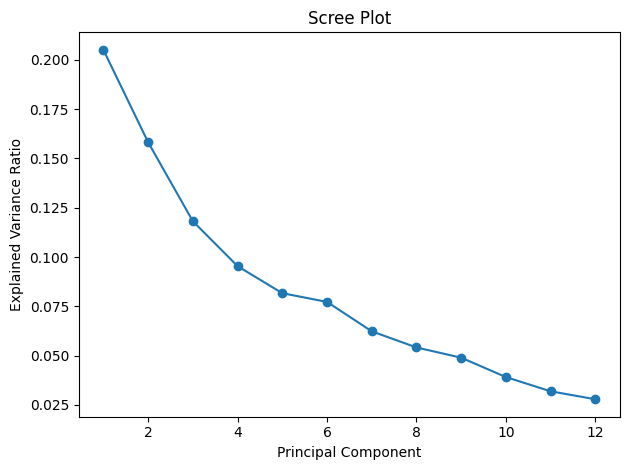

In [220]:
# Scree plot
plt.figure()
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.tight_layout()
plt.show()



In [221]:
# Loadings (feature contributions)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i}" for i in range(1, len(X_scaled.columns)+1)],
    index=X_scaled.columns
)

print("\nTop loadings for first 3 components:")
print(loadings.iloc[:, :3].sort_values(by="PC1", key=abs, ascending=False))


Top loadings for first 3 components:
              PC1       PC2       PC3
ALB      0.444759  0.206736 -0.255431
CHE      0.415830  0.301346  0.149286
AST     -0.368998  0.300398 -0.294274
GGT     -0.347538  0.450893  0.060221
BIL     -0.341958  0.035386 -0.290424
PROT     0.316292  0.314128 -0.300842
CHOL     0.286194  0.253189  0.406969
ALP     -0.184953  0.341466  0.428561
Age     -0.176667  0.068426  0.452210
CREA    -0.065059  0.114696  0.001318
ALT     -0.061613  0.427607 -0.034172
Sex_bin -0.001232  0.302639 -0.304041


### 3.2 UMAP – Nonlinear Manifold Exploration


PCA revealed a distributed but continuous variance structure across multiple physiological axes. Clinically, this reflects the fact that liver dysfunction does not affect a single pathway in isolation. Hepatic injury, cholestasis, and synthetic impairment often coexist in varying proportions. Since PCA is a linear projection, it may fail to capture nonlinear interactions between biomarkers, such as threshold effects or combined enzyme elevations that emerge only in specific physiological states. This brings us to the question:

<br>

**Problematique** :
Could a nonlinear embedding reveal a patient structure not captured by linear components?

<br>

We choose to use UMAP to answer our problematique, because it can explore whether patients are organized along a nonlinear manifold. UMAP preserves local neighborhood relationships, this means that patients with similar biochemical profiles remain close in the embedding. This will help us assess whether hidden subgroup structure, progression gradients or subtle separations emerge beyond linear projection.

<br>

**Observations** :

* The  UMAP embedding reveals projection displays 3 visually distinct dense regions. 2 larger upper structure and a lower structure and a smaller middle structure.
* The smaller middle area suggests a potentially separable subgroup rather than a purely continuous gradient.
* Interpretation: The nonlinear structure indicates localized density separation.
* Although UMAP reveals visually distinct regions, it does not confirm the presence of stable clusters
* The structure aligns with the PCA finding, but UMAP also highlights nonlinear organization that PCA could not show.

<br>


**Conclusion**

The UMAP projection suggests a structured nonlinear manifold composed of three geometric regions. This indicates that patient biochemical profiles may organize into latent subgroups rather than forming a purely continuous spectrum.





/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


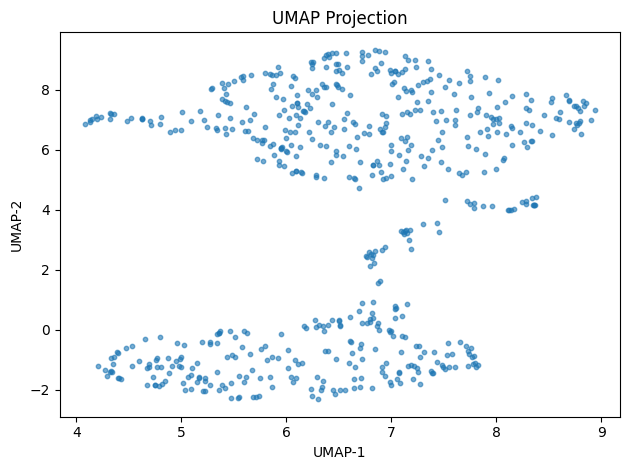

In [222]:
# -----------------------------
# 3.2 UMAP – Nonlinear Manifold Exploration
# -----------------------------

umap_model = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

### 3.3 KMeans – Discrete Structure Testing on PCA


Disease stages are often treated as discrete categories(hepatitis, fibrosis, cirrhosis). In practice, biochemical deterioration does not always progress in rigid steps. Patients frequently present with mixed profiles, where injury markers, cholestatic markers, and synthetic function decline at different rates. However, PCA and UMAP revealed structured yet largely continuous biochemical variation. This raises a key question:

<br>

**Problematique:**
Does the data truly form separable subgroups under a distance-based partitioning model?

<br>

We use KMeans to test this. It partitions observations into compact groups based on Euclidean distance. If strong and stable clusters emerge, this would support the existence of discrete biochemical subpopulations. If not, the structure is likely continuous.

<br>

**Observations** :
* The evaluation metrics consistently support **k = 2**.
* The silhouette score peaks at **0.60**, indicating strong separation and good cohesion.
*  For k > 2, silhouette values drop sharply. This indicates weak additional structure.
* The elbow plot shows no clear secondary break beyond k = 2.
* Although the Davies–Bouldin index decreases for higher k, this reflects fragmentation rather than meaningful separation.
<br>

 * Bootstrap analysis indicates strong clustering robustness, with a high mean ARI (~0.86), showing that the two-cluster structure is generally preserved under resampling.
 * The presence of occasional lower ARI values reflects sensitivity due to the small size of the minority cluster, but the overall stability remains high. This confirms that the detected bipartition is not random and represents a consistent geometric structure in the data.
<br>

* The final solution (k = 2) produces an imbalanced partition (579 vs 36). The small cluster is compact and well separated.

<br>

**Conclusion**

A compact and stable cluster emerges under a distance-based model. The data supports a strong bipartition: one small, clinically severe subgroup and one large majority group. Beyond two clusters, no meaningful discrete structure appears.The overall geometry remains largely continuous with a distinct pathological extreme rather than multiple rigid stages.



In [223]:
# ============================================================
# 3.3 KMeans – Discrete Structure Testing (on PCA space) + Stability + Sensitivity
# ============================================================

# Choose PCA dimension for clustering
# We choose the smallest number of PCs reaching ~74% variance
pca_cluster = PCA(n_components=6, random_state=42)
X_pca6 = pca_cluster.fit_transform(X_scaled)

print("\nPCA(6) explained variance ratio:", np.round(pca_cluster.explained_variance_ratio_, 4))
print("PCA(6) cumulative explained variance:", round(pca_cluster.explained_variance_ratio_.sum(), 4))


PCA(6) explained variance ratio: [0.2051 0.1583 0.1182 0.0954 0.0817 0.0772]
PCA(6) cumulative explained variance: 0.7358


In [224]:
# Evaluate KMeans across k on PCA(6)
k_values = range(2, 11)

inertias = []
sil_scores = []
db_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_pca6)

    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca6, labels))
    db_scores.append(davies_bouldin_score(X_pca6, labels))



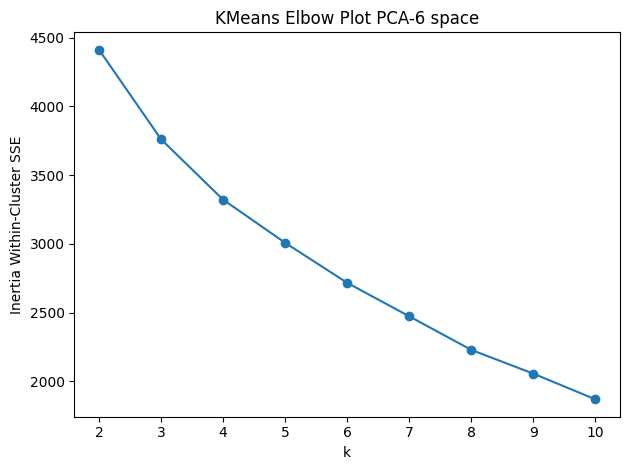

In [225]:

# Elbow plot
plt.figure()
plt.plot(list(k_values), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia Within-Cluster SSE")
plt.title("KMeans Elbow Plot PCA-6 space")
plt.tight_layout()
plt.show()

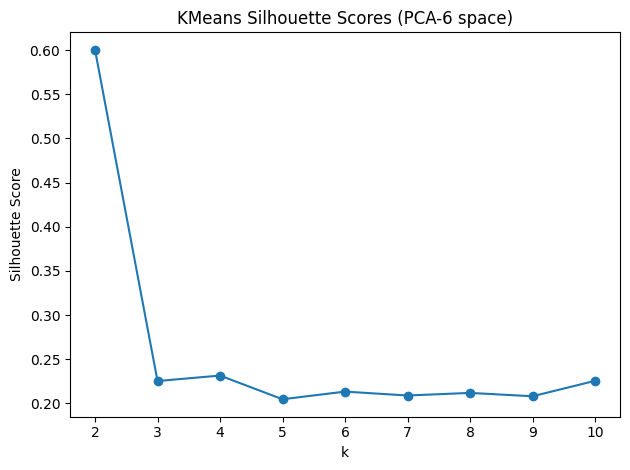

In [226]:
# Silhouette
plt.figure()
plt.plot(list(k_values), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score") # higher better
plt.title("KMeans Silhouette Scores (PCA-6 space)")
plt.tight_layout()
plt.show()

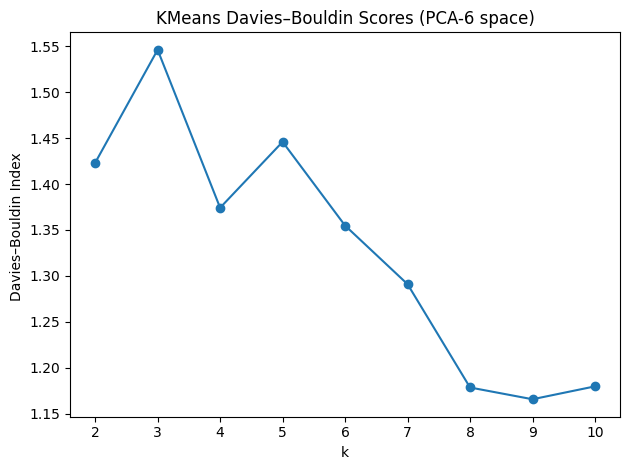


Best k by Silhouette: 2 (score= 0.6002 )
Best k by Davies–Bouldin: 9 (score= 1.1655 )


In [227]:
# Davies–Bouldin
plt.figure()
plt.plot(list(k_values), db_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Davies–Bouldin Index ") # lower better
plt.title("KMeans Davies–Bouldin Scores (PCA-6 space)")
plt.tight_layout()
plt.show()

best_k_sil = list(k_values)[int(np.argmax(sil_scores))]
best_k_db = list(k_values)[int(np.argmin(db_scores))]

print("\nBest k by Silhouette:", best_k_sil, "(score=", round(max(sil_scores), 4), ")")
print("Best k by Davies–Bouldin:", best_k_db, "(score=", round(min(db_scores), 4), ")")

In [228]:
# -----------------------------
#  Fit final KMeans model, choose silhouette-optimal k by default
# -----------------------------
k_final = best_k_sil
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=20)
clusters_kmeans = kmeans_final.fit_predict(X_pca6)

print("\nFinal KMeans (PCA-6 space):")
print("k =", k_final)
print("Silhouette =", round(silhouette_score(X_pca6, clusters_kmeans), 4))
print("Davies-Bouldin =", round(davies_bouldin_score(X_pca6, clusters_kmeans), 4))
print("Cluster sizes:", np.bincount(clusters_kmeans))


Final KMeans (PCA-6 space):
k = 2
Silhouette = 0.6002
Davies-Bouldin = 1.4231
Cluster sizes: [ 36 579]


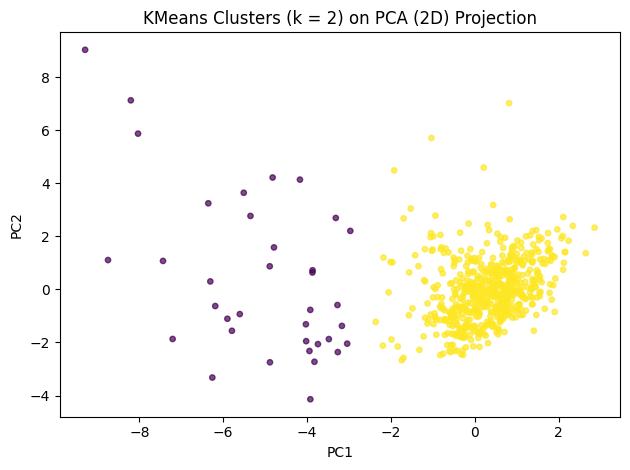


PCA (2D) explained variance ratio: [0.2051 0.1583]
PCA (2D) cumulative explained variance: 0.3634


In [229]:
# -----------------------------
# Visualize clusters on PCA(2) projection (visualization only)
# -----------------------------
pca_vis = PCA(n_components=2, random_state=42)
X_pca_2d = pca_vis.fit_transform(X_scaled)

plt.figure()
plt.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=clusters_kmeans,
    s=15,
    alpha=0.7
)
plt.title(f"KMeans Clusters (k = {k_final}) on PCA (2D) Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

print("\nPCA (2D) explained variance ratio:", np.round(pca_vis.explained_variance_ratio_, 4))
print("PCA (2D) cumulative explained variance:", round(pca_vis.explained_variance_ratio_.sum(), 4))

In [230]:
# -----------------------------
# Interpretability checks (cluster <=> category and feature means)
# -----------------------------
if "Category" in df.columns:
    # Align df to X_scaled index (should already match, but safer)
    df_aligned = df.loc[X_scaled.index].copy()
    df_aligned["Cluster"] = clusters_kmeans

    print("\nCluster x Category contingency table:")
    print(pd.crosstab(df_aligned["Cluster"], df_aligned["Category"]))

# Feature profile per cluster (in original feature space, not PCA)
df_profiles = df.loc[X_scaled.index, :].copy()
df_profiles["Cluster"] = clusters_kmeans

print("\nCluster-wise feature means (original feature columns):")
print(df_profiles.groupby("Cluster")[feature_cols].mean(numeric_only=True))


Cluster x Category contingency table:
Category  0=Blood Donor  0s=suspect Blood Donor  1=Hepatitis  2=Fibrosis  \
Cluster                                                                    
0                     4                       6            2           1   
1                   529                       1           22          20   

Category  3=Cirrhosis  
Cluster                
0                  23  
1                   7  

Cluster-wise feature means (original feature columns):
               Age   Sex_bin        ALB        ALP        ALT         AST  \
Cluster                                                                     
0        56.750000  0.722222  29.572222  94.925000  28.230556  104.058333   
1        46.827288  0.606218  42.369862  66.562694  28.455095   30.479275   

               BIL       CHE      CHOL        CREA         GGT       PROT  
Cluster                                                                    
0        50.708333  4.135278  3.984444  127

In [231]:
# -----------------------------
# Stability analysis (multiple random seeds) using ARI
# -----------------------------
# This tests whether the k=2 (or chosen k) partition is stable.
n_runs = 20
labels_runs = []

for seed in range(n_runs):
    km = KMeans(n_clusters=k_final, random_state=seed, n_init=20)
    labels_runs.append(km.fit_predict(X_pca6))

aris = []
for i in range(n_runs - 1):
    aris.append(adjusted_rand_score(labels_runs[i], labels_runs[i + 1]))

print("\nStability (ARI across successive seeds):")
print("Mean ARI:", round(float(np.mean(aris)), 4))
print("Std  ARI:", round(float(np.std(aris)), 4))
print("Min  ARI:", round(float(np.min(aris)), 4))
print("Max  ARI:", round(float(np.max(aris)), 4))


Stability (ARI across successive seeds):
Mean ARI: 1.0
Std  ARI: 0.0
Min  ARI: 1.0
Max  ARI: 1.0


In [232]:
# -----------------------------
# Sensitivity analysis: Balanced subsample
# -----------------------------
# Use balanced data as a robustness check .
if "df_balanced" in globals() and isinstance(df_balanced, pd.DataFrame):
    # Rebuild scaled features for balanced dataset
    from sklearn.preprocessing import StandardScaler

    X_bal = df_balanced[feature_cols].copy()

    scaler_bal = StandardScaler()
    X_bal_scaled = pd.DataFrame(
        scaler_bal.fit_transform(X_bal),
        columns=feature_cols
    )

    X_bal_pca6 = pca_cluster.fit_transform(X_bal_scaled)  # PCA refit on balanced for sensitivity

    km_bal = KMeans(n_clusters=k_final, random_state=42, n_init=20)
    labels_bal = km_bal.fit_predict(X_bal_pca6)

    print("\n[Balanced Sensitivity] Cluster sizes:", np.bincount(labels_bal))
    print("[Balanced Sensitivity] Silhouette:", round(silhouette_score(X_bal_pca6, labels_bal), 4))
    print("[Balanced Sensitivity] Davies-Bouldin:", round(davies_bouldin_score(X_bal_pca6, labels_bal), 4))

    if "Category" in df_balanced.columns:
        dfb = df_balanced.copy()
        dfb["Cluster"] = labels_bal
        print("\n[Balanced Sensitivity] Cluster x Category:")
        print(pd.crosstab(dfb["Cluster"], dfb["Category"]))




[Balanced Sensitivity] Cluster sizes: [ 32 132]
[Balanced Sensitivity] Silhouette: 0.4449
[Balanced Sensitivity] Davies-Bouldin: 1.4829

[Balanced Sensitivity] Cluster x Category:
Category  0=Blood Donor  0s=suspect Blood Donor  1=Hepatitis  2=Fibrosis  \
Cluster                                                                    
0                     0                       6            2           1   
1                    82                       1           22          20   

Category  3=Cirrhosis  
Cluster                
0                  23  
1                   7  


In [233]:
# -----------------------------
# Bootstrap stability
# -----------------------------
# Bootstrapping tests if the chosen k produces consistent partitions under resampling.
# We compute ARI between clusterings across bootstrap samples by clustering only
# on the bootstrap sample and comparing to clustering of the corresponding original subset.
n_boot = 20
boot_aris = []

# Reference clustering on full data (for subset comparison)
ref_labels = clusters_kmeans

for b in range(n_boot):
    boot_idx = resample(np.arange(X_pca6.shape[0]), replace=True, random_state=100 + b)
    X_boot = X_pca6[boot_idx]

    km_boot = KMeans(n_clusters=k_final, random_state=42, n_init=20)
    boot_labels = km_boot.fit_predict(X_boot)

    # Compare to reference labels restricted to those sampled indices
    # Note: indices are sampled with replacement; ARI is still usable but interpretation is approximate.
    ref_subset = ref_labels[boot_idx]
    boot_aris.append(adjusted_rand_score(ref_subset, boot_labels))

print("\nBootstrap robustness (ARI vs reference on bootstrapped indices):")
print("Mean ARI:", round(float(np.mean(boot_aris)), 4))
print("Std  ARI:", round(float(np.std(boot_aris)), 4))
print("Min  ARI:", round(float(np.min(boot_aris)), 4))
print("Max  ARI:", round(float(np.max(boot_aris)), 4))


Bootstrap robustness (ARI vs reference on bootstrapped indices):
Mean ARI: 0.8561
Std  ARI: 0.2484
Min  ARI: 0.0897
Max  ARI: 1.0


###  3.4 DBSCAN – Density Structure Testing on UMAP

KMeans tested spherical partitions, but UMAP suggested separated geometric regions. UMAP, however, revealed distinct geometric regions. In clinical hepatology, patient profiles often cluster around dominant biochemical patterns, such as predominant hepatocellular injury, cholestatic involvement, or synthetic dysfunction. We now test whether the geometric regions observed in UMAP correspond to true density-separated states and whether some patients behave as outliers.

<br>

**Problematique** : Do density-based groups and noise points emerge in the UMAP embedding?

<br>

DBSCAN finds clusters as dense regions separated by low-density gaps. It does not require choosing k. We want  DBSCAN identifies a density-based structure in the UMAP space.This directly tests whether the UMAP geometry reflects real density structure.

<br>

**Observations** :
* Across the tested eps values, the solution remains stable with 4 clusters and very few noise points.
* The selected eps (0.4424) yields **4 clusters and 8 noise observations**, indicating that most points belong to well-defined dense regions.
* The silhouette score (~0.47) indicates moderate separation between clusters
* The Davies–Bouldin index (~0.48) is low, suggesting compact clusters with good separation.

* Cluster sizes are uneven (344, 220, 23, 20).
* Two clusters are large and dense.
* Two clusters are small and compact.
* Only a small number of points are labeled as noise, meaning the structure is not driven by random scatter.

<br>

**Conslusion** :
 DBSCAN identifies four compact regions with limited noise, indicating that the data is not uniformly continuous. The structure contains two large dense regions and two smaller compact subregions. This confirms the presence of density-separated organization beyond simple bipartition.





/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


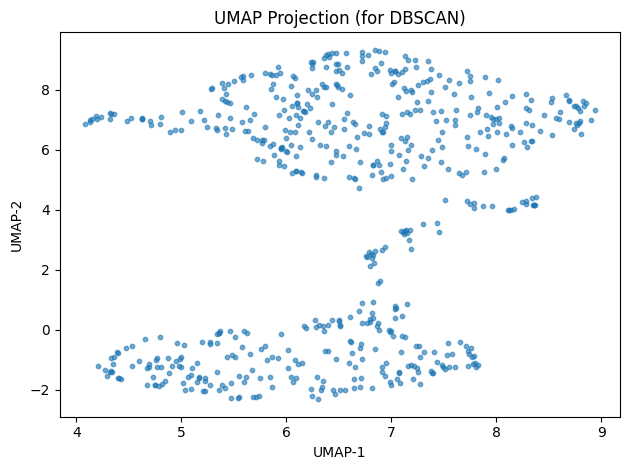

In [234]:
# ============================================================
# 3.4 DBSCAN – Density Structure Testing on UMAP
# ============================================================

# Fit UMAP
umap_model = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Projection (for DBSCAN)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

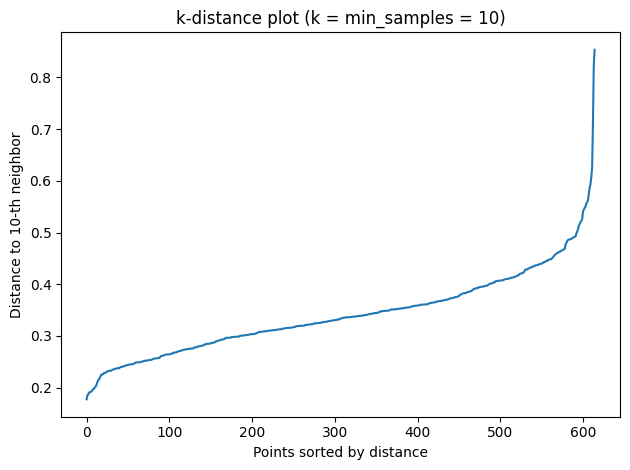

In [235]:
#  Choose eps using k-distance curve
# Rule: min_samples ~ 2*dim to 5*dim. Here dim=2, so 10 is a good start.
min_samples = 10

nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# k-distance = distance to the k-th nearest neighbor
kdist = np.sort(distances[:, -1])

plt.figure()
plt.plot(kdist)
plt.title(f"k-distance plot (k = min_samples = {min_samples})")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {min_samples}-th neighbor")
plt.tight_layout()
plt.show()

In [236]:
# -----------------------------
#  Run DBSCAN for a small eps grid around the upper tail of k-distance
# -----------------------------
# Use quantiles as a sane eps grid anchor
eps_grid = np.quantile(kdist, [0.90, 0.92, 0.94, 0.96, 0.98])

results = []
labels_store = {}

for eps in eps_grid:
    db = DBSCAN(eps=float(eps), min_samples=min_samples)
    labels = db.fit_predict(X_umap)

    n_noise = int(np.sum(labels == -1))
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Silhouette/DB only meaningful if >=2 clusters among non-noise points
    mask = labels != -1
    if n_clusters >= 2 and mask.sum() > n_clusters:
        sil = silhouette_score(X_umap[mask], labels[mask])
        dbi = davies_bouldin_score(X_umap[mask], labels[mask])
    else:
        sil = np.nan
        dbi = np.nan

    results.append({
        "eps": float(eps),
        "n_clusters": n_clusters,
        "n_noise": n_noise,
        "silhouette": sil,
        "davies_bouldin": dbi
    })
    labels_store[float(eps)] = labels

results_df = pd.DataFrame(results).sort_values(["silhouette"], ascending=False)
print("\nDBSCAN eps grid results:")
print(results_df)

# Pick best eps by highest silhouette (ignoring NaN)
valid = results_df.dropna(subset=["silhouette"])
if len(valid) > 0:
    best_eps = float(valid.iloc[0]["eps"])
else:
    # fallback: pick eps with most clusters but not all noise
    best_eps = float(results_df.sort_values(["n_clusters", "n_noise"], ascending=[False, True]).iloc[0]["eps"])

print("\nChosen eps:", best_eps)


DBSCAN eps grid results:
        eps  n_clusters  n_noise  silhouette  davies_bouldin
0  0.442411           4        8    0.472654        0.475000
1  0.454795           4        8    0.472654        0.475000
2  0.467368           4        2    0.464390        0.480251
3  0.491344           4        2    0.464390        0.480251
4  0.546935           4        1    0.461695        0.484166

Chosen eps: 0.4424105249152796



Final DBSCAN on UMAP:
eps = 0.4424105249152796
min_samples = 10
n_clusters = 4
n_noise = 8
Silhouette (non-noise) = 0.4727
Davies–Bouldin (non-noise) = 0.475


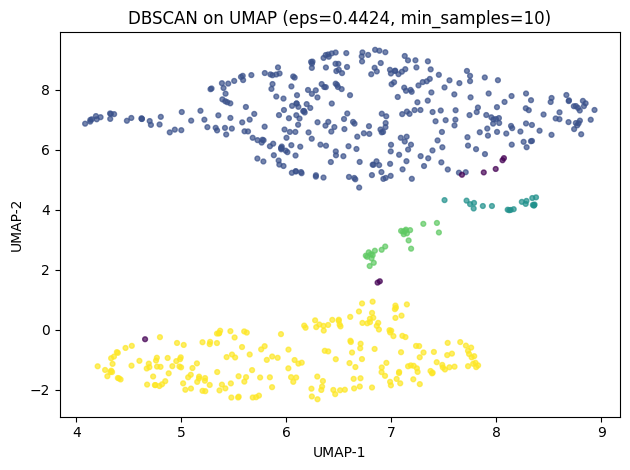


Cluster sizes (excluding noise):
{np.int64(0): 344, np.int64(1): 20, np.int64(2): 23, np.int64(3): 220}

Noise count: 8


In [237]:
# -----------------------------
# Fit final DBSCAN + plot
# -----------------------------
labels_dbscan = labels_store[best_eps]
n_noise = int(np.sum(labels_dbscan == -1))
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

print("\nFinal DBSCAN on UMAP:")
print("eps =", best_eps)
print("min_samples =", min_samples)
print("n_clusters =", n_clusters)
print("n_noise =", n_noise)

# Metrics on non-noise only
mask = labels_dbscan != -1
if n_clusters >= 2 and mask.sum() > n_clusters:
    print("Silhouette (non-noise) =", round(silhouette_score(X_umap[mask], labels_dbscan[mask]), 4))
    print("Davies–Bouldin (non-noise) =", round(davies_bouldin_score(X_umap[mask], labels_dbscan[mask]), 4))
else:
    print("Silhouette / DB index not defined (need >=2 clusters excluding noise).")

# Plot clusters (noise in black)
plt.figure()
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels_dbscan, s=12, alpha=0.7)
plt.title(f"DBSCAN on UMAP (eps={best_eps:.4f}, min_samples={min_samples})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

# Cluster sizes (excluding noise)
cluster_ids = [c for c in np.unique(labels_dbscan) if c != -1]
sizes = {c: int(np.sum(labels_dbscan == c)) for c in cluster_ids}
print("\nCluster sizes (excluding noise):")
print(sizes)

print("\nNoise count:", int(np.sum(labels_dbscan == -1)))



###  3.5 GMM – Probabilistic Mixture Testing on PCA



Previous analyses showed that biochemical variation in this Hepatitis C cohort is structured and multidimensional. The data does not behave as purely categorical, nor as fully continuous without structure. Instead, patient profiles appear to organize along overlapping physiological states. These states likely reflect varying combinations of hepatic injury, cholestasis, and synthetic function. We now test a third hypothesis: the data may follow a mixture of elliptical components with soft overlap.


<br>

**Problématique** : Does the PCA-reduced feature space support a Gaussian mixture structure, and how many components are justified?

<br>

A Gaussian Mixture Model (GMM) models the data as a weighted sum of Gaussian components. It allows elliptical clusters and soft membership. Model size can be selected with **BIC/AIC**. This gives a principled choice for k.

<br>

**Observations** :
* PCA with 6 components retains 73.6% of total variance. The structure is moderately compressed but not low-dimensional.
* BIC is minimized at **k = 5**
* AIC continues decreasing up to **k = 9**.
* Thus we select BIC since it is more conservative, so k = 5*

<br>

* The final GMM produces five components with sizes **[219, 61, 282, 49, 4]**. The distribution is imbalanced. One component is very small (4 points).
* Assignment confidence is high. The mean responsibility is **0.959** and the median is **0.994**. Most points are strongly assigned to one component.
* However, separation quality is low.
* The silhouette score is **0.1966**, indicating weak cluster separation.
* The Davies–Bouldin index is **1.97**, suggesting overlapping components.

<br>

* Stability across random seeds is strong.
* The mean ARI is **0.886** with low variance. The partition is reproducible.
* Agreement with KMeans is very low (**ARI = 0.117**). The two methods capture different structures.

<br>

**Conclusion** : The PCA space supports a Gaussian mixture structure with 5 components ( using BIC). The model is stable across seeds and assignments are confident. However, geometric separation is weak, as shown by the low silhouette score and high Davies–Bouldin index. This indicates overlapping components not clearly separated clusters.




KMeans tests compact partitions. DBSCAN tests density gaps in UMAP. We now test a third hypothesis: the data may follow a mixture of elliptical components with soft overlap.

Previous analyses showed that biochemical variation in this Hepatitis C cohort is structured and multidimensional. The data does not behave as purely categorical, nor as fully continuous without structure. Instead, patient profiles appear to organize along overlapping physiological states. These states likely reflect varying combinations of hepatic injury, cholestasis, and synthetic function.

<br>

**Problématique** : Does the PCA-reduced feature space support a Gaussian mixture structure, and how many components are justified?

<br>

A Gaussian Mixture Model (GMM) models the data as a weighted sum of Gaussian components. It allows elliptical clusters and soft membership. Model size can be selected with **BIC/AIC**. This gives a principled choice for k.

<br>

**Observations** :
* PCA with 6 components retains 73.6% of total variance. The structure is moderately compressed but not low-dimensional.
* BIC is minimized at **k = 5**
* AIC continues decreasing up to **k = 9**.
* Thus we select BIC since it is more conservative, so k = 5*

<br>

* The final GMM produces five components with sizes **[219, 61, 282, 49, 4]**. The distribution is imbalanced. One component is very small (4 points).
* Assignment confidence is high. The mean responsibility is **0.959** and the median is **0.994**. Most points are strongly assigned to one component.
* However, separation quality is low.
* The silhouette score is **0.1966**, indicating weak cluster separation.
* The Davies–Bouldin index is **1.97**, suggesting overlapping components.

<br>

* Stability across random seeds is strong.
* The mean ARI is **0.886** with low variance. The partition is reproducible.
* Agreement with KMeans is very low (**ARI = 0.117**). The two methods capture different structures.

<br>

**Conclusion** : The PCA space supports a Gaussian mixture structure with 5 components ( using BIC). The model is stable across seeds and assignments are confident. However, geometric separation is weak, as shown by the low silhouette score and high Davies–Bouldin index. This indicates overlapping components not clearly separated clusters.




In [238]:
# ============================================================
# 3.5 GMM – Probabilistic Mixture Testing on PCA
# ============================================================

#  PCA space for clustering (same as KMeans)

pca_cluster = PCA(n_components=6, random_state=42)
X_pca6 = pca_cluster.fit_transform(X_scaled)

print("\nPCA(6) cumulative explained variance:", round(pca_cluster.explained_variance_ratio_.sum(), 4))



PCA(6) cumulative explained variance: 0.7358


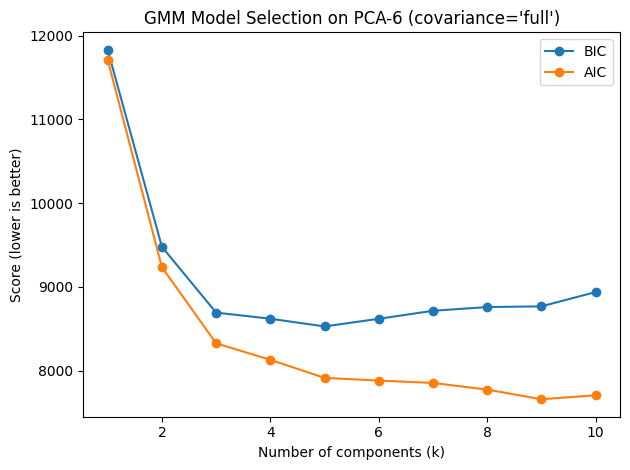


Best k by BIC: 5 (BIC= 8527.07 )
Best k by AIC: 9 (AIC= 7657.0 )


In [239]:

# -----------------------------
# Fit GMM for a range of components + compute BIC/AIC
# -----------------------------
k_values = range(1, 11)

bics, aics = [], []
gmm_models = {}

# Covariance type options: 'full' is most flexible and common for PCA space.
cov_type = "full"

for k in k_values:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=cov_type,
        random_state=42,
        n_init=10
    )
    gmm.fit(X_pca6)

    bics.append(gmm.bic(X_pca6))
    aics.append(gmm.aic(X_pca6))
    gmm_models[k] = gmm

# Plot BIC/AIC
plt.figure()
plt.plot(list(k_values), bics, marker="o", label="BIC")
plt.plot(list(k_values), aics, marker="o", label="AIC")
plt.xlabel("Number of components (k)")
plt.ylabel("Score (lower is better)")
plt.title(f"GMM Model Selection on PCA-6 (covariance='{cov_type}')")
plt.legend()
plt.tight_layout()
plt.show()

best_k_bic = list(k_values)[int(np.argmin(bics))]
best_k_aic = list(k_values)[int(np.argmin(aics))]

print("\nBest k by BIC:", best_k_bic, "(BIC=", round(min(bics), 2), ")")
print("Best k by AIC:", best_k_aic, "(AIC=", round(min(aics), 2), ")")

In [240]:
# Choose BIC by default (more conservative)
k_final = best_k_bic
gmm_final = gmm_models[k_final]

In [241]:
# -----------------------------
# Hard labels + soft responsibilities
# -----------------------------
labels_gmm = gmm_final.predict(X_pca6)
proba_gmm = gmm_final.predict_proba(X_pca6)  # responsibilities
confidence = proba_gmm.max(axis=1)           # max membership probability per point

print("\nFinal GMM:")
print("k =", k_final)
print("Cluster sizes:", np.bincount(labels_gmm))
print("Mean assignment confidence:", round(float(np.mean(confidence)), 4))
print("Median assignment confidence:", round(float(np.median(confidence)), 4))

# Optional: separation metrics (defined if k>=2)
if k_final >= 2:
    print("Silhouette (PCA-6, hard labels):", round(silhouette_score(X_pca6, labels_gmm), 4))
    print("Davies–Bouldin (PCA-6, hard labels):", round(davies_bouldin_score(X_pca6, labels_gmm), 4))


Final GMM:
k = 5
Cluster sizes: [219  61 282  49   4]
Mean assignment confidence: 0.9589
Median assignment confidence: 0.994
Silhouette (PCA-6, hard labels): 0.1966
Davies–Bouldin (PCA-6, hard labels): 1.9702


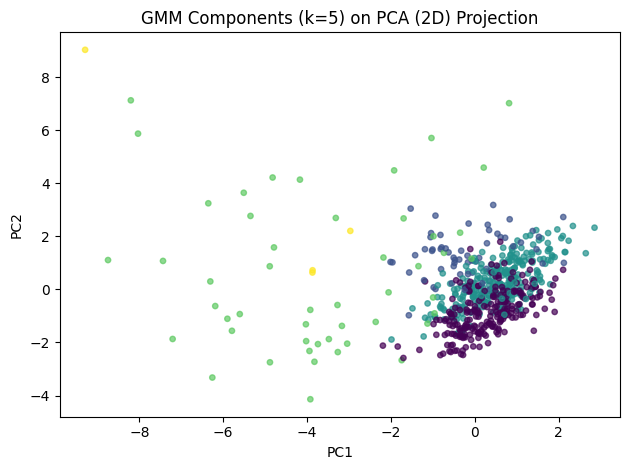

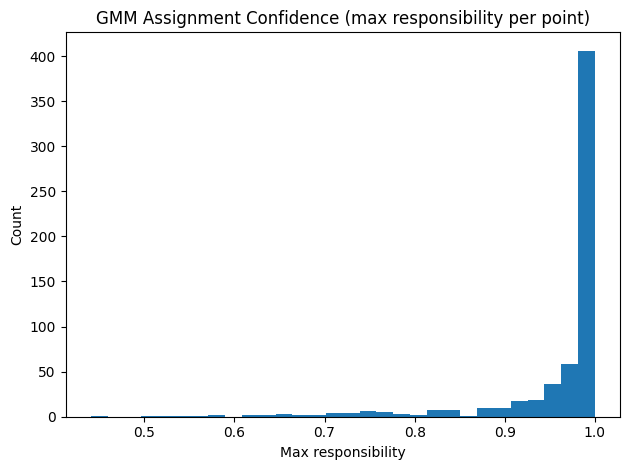

In [242]:
# -----------------------------
# Visualize on PCA(2) with confidence shading (simple)
# -----------------------------
pca_vis = PCA(n_components=2, random_state=42)
X_pca2 = pca_vis.fit_transform(X_scaled)

plt.figure()
plt.scatter(
    X_pca2[:, 0],
    X_pca2[:, 1],
    c=labels_gmm,
    s=15,
    alpha=0.7
)
plt.title(f"GMM Components (k={k_final}) on PCA (2D) Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# Plot confidence distribution
plt.figure()
plt.hist(confidence, bins=30)
plt.title("GMM Assignment Confidence (max responsibility per point)")
plt.xlabel("Max responsibility")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [243]:
# -----------------------------
# Stability across random seeds (ARI)
# -----------------------------
# Refit with different seeds. Compare partitions to the reference labels.
n_runs = 20
aris = []

for seed in range(n_runs):
    gmm = GaussianMixture(
        n_components=k_final,
        covariance_type=cov_type,
        random_state=seed,
        n_init=5
    )
    labels_seed = gmm.fit_predict(X_pca6)
    aris.append(adjusted_rand_score(labels_gmm, labels_seed))

print("\nGMM Stability vs reference (ARI across seeds):")
print("Mean ARI:", round(float(np.mean(aris)), 4))
print("Std  ARI:", round(float(np.std(aris)), 4))
print("Min  ARI:", round(float(np.min(aris)), 4))
print("Max  ARI:", round(float(np.max(aris)), 4))




GMM Stability vs reference (ARI across seeds):
Mean ARI: 0.8859
Std  ARI: 0.0472
Min  ARI: 0.8345
Max  ARI: 0.9557


In [244]:
# -----------------------------
#  Compare GMM vs KMeans (if you have clusters_kmeans from earlier)
# -----------------------------
# If clusters_kmeans exists, this tells if they align.
if "clusters_kmeans" in globals():
    print("\nAgreement with KMeans (ARI):", round(adjusted_rand_score(clusters_kmeans, labels_gmm), 4))


Agreement with KMeans (ARI): 0.1171


### 3.6 Isolation Forest – Detection of Extreme Biochemical Profiles


Previous models identified structured latent states in the biochemical space. KMeans revealed a dominant bipartition. DBSCAN detected density-separated regions. GMM identified overlapping probabilistic components. However, clustering methods focus on grouping patients into coherent profiles. They do not directly test whether rare and structurally abnormal profiles exist outside these patterns. Some patients may present with extreme or atypical biochemical signatures that do not align with dominant physiological states. These cases may reflect severe dysfunction, mixed pathology, or rare phenotypes. So we ask :

<br>

**Problematique** : Do rare, structurally abnormal biomarker combinations exist beyond the latent states identified by clustering?

<br>

Isolation Forest is designed for anomaly detection. It isolates observations that require fewer random splits in the feature space. Unusual combinations of biomarkers are therefore detected without assuming any cluster structure.

<br>

**Observations** :

* Isolation Forest flagged 13 patients (2%), consistent with the contamination setting.
* The anomaly score distribution is strongly right-skewed. Most patients cluster around similar scores. A small extreme tail is present.
* The anomaly threshold (~0.002) lies above the 98th percentile. Only the most extreme biochemical combinations are selected.

<br>

**Biochemical pattern of anomalies:**
* Markedly elevated **GGT** (median 146 vs 23).
* Strong elevation of **AST** (median 110 vs 25).
* Elevated **ALP** and **bilirubin**.
* Reduced **albumin** (median 30 vs 42).
* Slightly older age.

<br>

* The largest median shifts occur in **GGT (+123)** and **AST (+85)**, indicating severe hepatocellular and cholestatic involvement.

<br>

**Conclusion** :
 Rare and structurally abnormal biochemical profiles exist beyond the dominant latent states. Isolation Forest identifies a small subset with markedly elevated injury and cholestatic markers combined with reduced synthetic function. These profiles represent extreme physiological deviation rather than random variation.

In [245]:
# ============================================================
# 3.6 Isolation Forest – Detection of Extreme Biochemical Profiles
# ============================================================

# -----------------------------
# Fit Isolation Forest
# -----------------------------
contamination = 0.02  # ~2% anomalies (adjust if needed)
iso = IsolationForest(
    n_estimators=500,
    contamination=contamination,
    random_state=42
)

iso.fit(X_scaled)

IsolationForest(contamination=0.02, n_estimators=500, random_state=42)

In [246]:
# -----------------------------
# Anomaly scores + flags
# -----------------------------
# decision_function: higher = more normal, lower = more abnormal
normality_score = iso.decision_function(X_scaled)

# Convert to "anomaly score": higher = more anomalous (easier to interpret)
anomaly_score = -normality_score

# predict: -1 = anomaly, +1 = normal
pred = iso.predict(X_scaled)
is_anomaly = (pred == -1)

print("\nIsolation Forest results:")
print("Contamination:", contamination)
print("Flagged anomalies:", int(is_anomaly.sum()), "out of", X_scaled.shape[0])



Isolation Forest results:
Contamination: 0.02
Flagged anomalies: 13 out of 615


In [247]:
# -----------------------------
# Attach results to a results table
# -----------------------------
results = df.loc[X_scaled.index].copy()
results["IF_is_anomaly"] = is_anomaly.astype(int)
results["IF_anomaly_score"] = anomaly_score

# Rank most anomalous
results_sorted = results.sort_values("IF_anomaly_score", ascending=False)

print("\nTop 15 most anomalous observations (by IF_anomaly_score):")
cols_to_show = [c for c in (["IF_anomaly_score", "IF_is_anomaly"] + feature_cols) if c in results_sorted.columns]
print(results_sorted[cols_to_show].head(15))


Top 15 most anomalous observations (by IF_anomaly_score):
     IF_anomaly_score  IF_is_anomaly   Age  Sex_bin   ALB    ALP    ALT  \
539          0.131351              1  59.0        0  19.3  208.2  325.3   
610          0.082143              1  62.0        0  32.0  416.6    5.9   
558          0.065897              1  56.0        1  37.0  114.0   27.8   
590          0.048532              1  46.0        1  20.0   66.2   62.0   
537          0.039134              1  71.0        1  14.9   69.8   19.7   
533          0.026233              1  47.0        1  22.5  124.0   79.5   
606          0.023888              1  49.0        0  33.0  190.7    1.2   
536          0.022934              1  55.0        1  47.3  106.0  208.8   
598          0.018023              1  58.0        1  31.0  143.1    7.0   
597          0.006512              1  56.0        1  30.0   40.4    0.9   
538          0.005799              1  74.0        1  20.3   84.0   22.8   
605          0.002386              1  42.

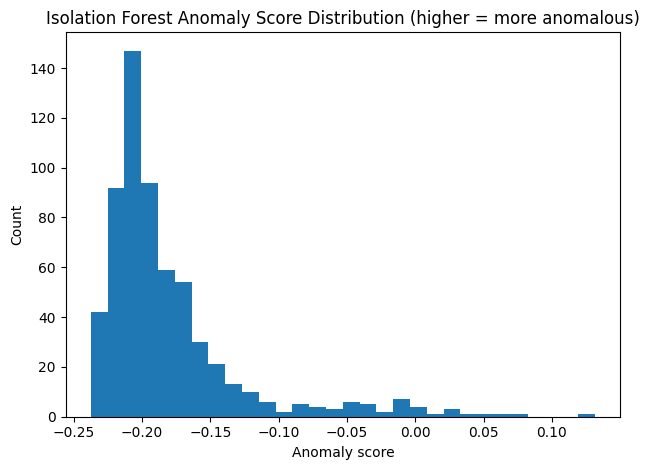

In [248]:
# -----------------------------
#  Score distribution plot
# -----------------------------
plt.figure()
plt.hist(results["IF_anomaly_score"], bins=30)
plt.title("Isolation Forest Anomaly Score Distribution (higher = more anomalous)")
plt.xlabel("Anomaly score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [249]:
# -----------------------------
# Threshold + quick tail check
# -----------------------------
threshold = results.loc[is_anomaly, "IF_anomaly_score"].min() if is_anomaly.any() else np.nan
print("\nAnomaly score threshold (minimum among flagged anomalies):", threshold)

print("\nQuantiles of anomaly score:")
print(results["IF_anomaly_score"].quantile([0.5, 0.9, 0.95, 0.98, 0.99]))


Anomaly score threshold (minimum among flagged anomalies): 0.0019691517574746964

Quantiles of anomaly score:
0.50   -1.974326e-01
0.90   -1.255591e-01
0.95   -5.168907e-02
0.98    1.916869e-16
0.99    2.375418e-02
Name: IF_anomaly_score, dtype: float64


In [250]:
# -----------------------------
#  Summarize what is extreme among anomalies
#  Compare anomalies vs normals using robust stats (median + IQR)
# -----------------------------
anoms = results[results["IF_is_anomaly"] == 1]
norms = results[results["IF_is_anomaly"] == 0]

summary_rows = []
for c in feature_cols:
    if c not in results.columns:
        continue
    if not pd.api.types.is_numeric_dtype(results[c]):
        continue

    a_med = float(anoms[c].median()) if len(anoms) else np.nan
    n_med = float(norms[c].median()) if len(norms) else np.nan

    a_q1 = float(anoms[c].quantile(0.25)) if len(anoms) else np.nan
    a_q3 = float(anoms[c].quantile(0.75)) if len(anoms) else np.nan
    n_q1 = float(norms[c].quantile(0.25)) if len(norms) else np.nan
    n_q3 = float(norms[c].quantile(0.75)) if len(norms) else np.nan

    summary_rows.append({
        "Feature": c,
        "Anom_median": a_med,
        "Norm_median": n_med,
        "Anom_IQR": a_q3 - a_q1 if len(anoms) else np.nan,
        "Norm_IQR": n_q3 - n_q1 if len(norms) else np.nan,
        "Median_diff(Anom-Norm)": a_med - n_med if len(anoms) else np.nan
    })

summary = pd.DataFrame(summary_rows).sort_values("Median_diff(Anom-Norm)", key=lambda s: s.abs(), ascending=False)

print("\nRobust comparison: anomalies vs normals (sorted by |median diff|):")
print(summary.head(12))


Robust comparison: anomalies vs normals (sorted by |median diff|):
    Feature  Anom_median  Norm_median  Anom_IQR  Norm_IQR  \
10      GGT       146.30        23.10    201.90   22.6000   
5       AST       110.30        25.70     90.90   10.7500   
3       ALP       106.00        66.20     64.10   25.7000   
6       BIL        37.00         7.25     60.10    5.8750   
2       ALB        30.00        42.00     12.70    6.3000   
0       Age        56.00        47.00     10.00   15.0000   
11     PROT        65.30        72.20     18.00    5.9000   
4       ALT        19.70        23.00     56.10   16.4500   
7       CHE         5.33         8.29      4.95    2.6000   
8      CHOL         3.92         5.30      1.97    1.4275   
9      CREA        76.00        77.00     42.00   20.0000   
1   Sex_bin         1.00         1.00      1.00    1.0000   

    Median_diff(Anom-Norm)  
10                  123.20  
5                    84.60  
3                    39.80  
6                    2

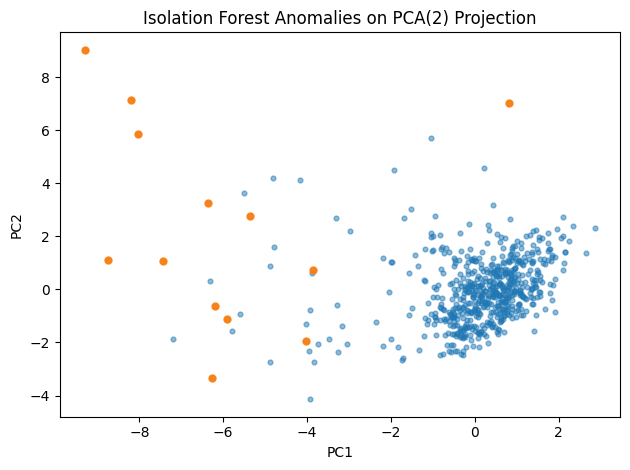


PCA(2) explained variance ratio: [0.2051 0.1583]


In [251]:
# -----------------------------
# Visualize anomalies on PCA(2) for context
# -----------------------------

pca_vis = PCA(n_components=2, random_state=42)
X_pca2 = pca_vis.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], s=12, alpha=0.5)
plt.scatter(X_pca2[is_anomaly, 0], X_pca2[is_anomaly, 1], s=25, alpha=0.9)
plt.title("Isolation Forest Anomalies on PCA(2) Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

print("\nPCA(2) explained variance ratio:", np.round(pca_vis.explained_variance_ratio_, 4))

## 4. Model Evaluation & Robustness – Integrated Assessment



During this project we used multiple unsupervised methods to the same biochemical feature space. Each method tested a different structural assumption about our data.
In this section we will assess if these findings are indicate a robust and coherent latent structure in the dataset?


**Our Observations** :

* PCA shows variance distributed across several components. No single dominant axis explains the data. The structure is multidimensional.
* KMeans identifies one strong and stable bipartition. The silhouette score is high and bootstrap resampling confirms stability. This indicates a dominant global separation.
* DBSCAN detects four density-based regions with minimal noise. Two regions are large. Two are smaller and compact. The structure remains stable across nearby eps values. This indicates internal density organization within the global structure.
* GMM supports five probabilistic components based on BIC. The components are stable across random seeds. However, geometric separation is weak. This indicates overlapping latent states rather than sharply separated clusters.
* Isolation Forest identifies a small extreme subset (~2%). These profiles show marked biochemical deviation. The flagged cases are consistent with the contamination parameter. This confirms the presence of rare extreme patterns outside the dominant structure.

**Interpretation** : We can observe the data contains a strong global separation. Within that global structure, local density regions exist and overlap.
Addtionally, a small number of extreme profiles lie outside the main pattern.
All major findings are stable across resampling, seed variation, or parameter sensitivity.


## 5. Methodological Limitations



 * There is no temporal information. Latent states are inferred from static biomarker patterns.

 * Preprocessing affects results.Through log transformation and scaling the distance structure changes. Different preprocessing choices could modify clustering geometry.

* The structural findings depend on projection methods.PCA and UMAP reduce dimensionality before clustering. As such their output changes with parameter settings. Some geometric patterns may reflect embedding choices.

* Clustering results depend on model assumptions.Each method produced a different number of groups. There is no single fixed cluster count.
  * KMeans assumes spherical structure.
  * DBSCAN assumes density separation.
  * GMM assumes Gaussian mixtures.

* Separation weakens beyond the main bipartition.
  * GMM shows low silhouette values.
  * Additional KMeans partitions reduce cohesion.
  * Internal substructure is overlapping. Subgroup interpretation must remain cautious.

 * All validation metrics are internal. Silhouette, Davies–Bouldin, and ARI measure geometric consistency. They do not confirm clinical validity. No external outcome was used for validation.

To conclude, the dataset shows stable geometric organization. Subgroup interpretation depends on modeling assumptions and parameter selection. The findings describe statistical structure, not confirmed clinical staging.


## 6. Conclusion


This project applied multiple unsupervised learning methods to a Hepatitis C biochemical dataset, including preprocessing, dimensionality reduction (PCA, UMAP), distance-based clustering (KMeans), density-based clustering (DBSCAN), probabilistic mixture modeling (GMM), and anomaly detection (Isolation Forest).

The overall structure of the dataset is organized but not rigid. There is one dominant separation in the population. Within it, overlapping biochemical patterns exist. A small number of patients show marked deviation from the main structure.

In clinical terms, the data supports the presence of a major division between broadly preserved and markedly altered biochemical states. Inside this division, patients display graded and overlapping patterns of hepatic injury, cholestasis, and synthetic function. A minority present extreme profiles that may correspond to severe or atypical presentations.

The biochemical landscape is structured, multidimensional, and partially continuous.
